<a href="https://colab.research.google.com/github/aliaa-anx/celebrity-recognition-model/blob/aliaa/vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports and Configuration**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/lfw.zip" -d /content/

replace /content/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:

import os
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# The unzipped folder will be in the root content directory
DATASET_PATH = "/content/lfw"

# Double check if it's nested (sometimes zips create a folder inside a folder)
if os.path.exists("/content/lfw/lfw"):
    DATASET_PATH = "/content/lfw/lfw"

print(f"Dataset path set to: {DATASET_PATH}")

Dataset path set to: /content/lfw


**Class Discovery**

In [36]:
# Scan directory for celebrity folders
all_celebs = [c for c in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, c))]

# Filter: Only keep celebs with at least 30 images
# This reduces the class count but drastically improves accuracy
MIN_IMAGES = 30
celebs = [c for c in all_celebs if len(os.listdir(os.path.join(DATASET_PATH, c))) >= MIN_IMAGES]

# Create a dictionary mapping class names to integer IDs
label_map = {celebrity: id for id, celebrity in enumerate(celebs)}
NUM_CLASSES = len(celebs)

print(f"Found {len(all_celebs)} total folders.")
print(f"Selected {NUM_CLASSES} celebrities with >= {MIN_IMAGES} images.")

Found 5749 total folders.
Selected 34 celebrities with >= 30 images.


**load image paths**

In [37]:
image_paths = []
labels = []

for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        image_paths.append(os.path.join(celebrity_path, img_name))
        labels.append(label_map[celebrity])

# Convert to numpy arrays for easier indexing
image_paths = np.array(image_paths)
labels = np.array(labels, dtype=np.int32)

print(f"Total images found: {len(image_paths)}")

Total images found: 2370


**shuffling and splittingData**

In [38]:
# Generate shuffled indices
indices = np.arange(len(image_paths))
np.random.seed(42)
np.random.shuffle(indices)

# Apply shuffle
image_paths = image_paths[indices]
labels = labels[indices]

# Define split boundaries
train_end = int(0.7 * len(image_paths))
val_end   = int(0.85 * len(image_paths))

# Create splits
train_paths = image_paths[:train_end]
val_paths   = image_paths[train_end:val_end]
test_paths  = image_paths[val_end:]

train_labels = labels[:train_end]
val_labels   = labels[train_end:val_end]
test_labels  = labels[val_end:]

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

Training set: 1659 images
Validation set: 355 images
Test set: 356 images


**Data Augmentation Pipeline**

In [39]:
# Define augmentation sequence
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),
])

# Numpy wrapper for Albumentations
def augment_np(image, label):
    image = (image * 255.0).numpy().astype("uint8")
    aug = train_transform(image=image)["image"]
    aug = aug.astype("float32") / 255.0
    return aug, label

# TensorFlow wrapper
def tf_augment(image, label):
    image, label = tf.py_function(func=augment_np, inp=[image, label], Tout=(tf.float32, tf.int32))
    # Explicitly set shape because py_function loses shape info
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())
    return image, label

**Preprocessing & Dataset Generator**

In [40]:
def load_and_preprocess(path, label):
    # Load image file
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize to VGG standard input
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return image, label

def create_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    # Load and resize images
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation only if requested (usually for training set)
    if augment:
        ds = ds.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

**Initialize Datasets**

In [41]:
print("Creating datasets...")
train_dataset = create_dataset(train_paths, train_labels, augment=True)
val_dataset   = create_dataset(val_paths,   val_labels,   augment=False)
test_dataset  = create_dataset(test_paths,  test_labels,  augment=False)

print("Data pipeline ready for VGG-19!")

Creating datasets...
Data pipeline ready for VGG-19!


**model imports and configuration**

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
#configuration for VF-19
IMG_SHAPE =(224, 224, 3)
IMG_SIZE = IMG_SHAPE[0] # Extract image size from IMG_SHAPE
BATCH_SIZE = 32 # Define a batch size

print(f"Model will classify {NUM_CLASSES} classes and image shape is {IMG_SHAPE}")

Model will classify 34 classes and image shape is (224, 224, 3)


***define vgg architecture***

In [43]:
def build_vgg19_model(input_shape, num_classes):
    model= models.Sequential(name="VGG-19")
    # Block 1  contains 2 convultional layers and 1 max pooling layer
    # activation relu>> to add complexity and non-linearity to the model
    #padding same>> to maintain the spatial dimensions of the input (will be halved after max pooling)

    # first and 2nd blocks have 64 filters each and rest of the blocks as we go
    # deeper will have 128,256,512,512 filters respectively  to notioce more complex features as we go deeper


    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 2 contains 2 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 3 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 4 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 5 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


    # Flattening the layers to feed into fully connected layers(Dense layers considered the brain of the model)
    model.add(layers.Flatten())

    #we have 3 dense layers in VGG-19

    # dense layer-1 with 4096 neurons and relu activation function
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5)) #dropout to prevent overfitting


    # dense layer-2 with 4096 neurons and relu activation function
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # output layer with number of neurons equal to number of classes and softmax activation function
    model.add(layers.Dense(num_classes, activation='softmax')) #softmax for multiclass classification
    return model

print("VGG-19 architecture defined. ")

VGG-19 architecture defined. 


***instintiate the model and summarize it***

In [44]:
#call the function to build the model
vgg19_model= build_vgg19_model(IMG_SHAPE, NUM_CLASSES)

vgg19_model.summary()


Model: "VGG-19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 139,709,538 (532.95 MB)

 Trainable params: 139,709,538 (532.95 MB)

 Non-trainable params: 0 (0.00 B)

***compile the model***

In [45]:
#define the optimizer used adam with a learning rate of 0.0001(low)for stability
optimizer= optimizers.Adam(learning_rate=0.0001)

#compile the model with "sparse"categorical crossentropy loss(beacuse categorical cross entropy alone expects one-hot encoded labels)
vgg19_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully with custom optimizer.")

Model compiled successfully with custom optimizer.


***define callbacks***

In [46]:
# define callbacks to manage training process
callbacks = [
    tf.keras.callbacks.ModelCheckpoint( "vgg19_best_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    ),
    # to stop training when the model stops improving to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

***training the model***

In [47]:
print("Starting model training...")
# Train the model
history = vgg19_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Starting model training...
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1997 - loss: 3.4381   
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to vgg19_best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.1998 - loss: 3.4359 - val_accuracy: 0.2000 - val_loss: 3.1998
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.2569 - loss: 3.0872
Epoch 2: val_accuracy did not improve from 0.20000
52/52 ━━━━━━━━━━━━━━━━━━━━ 70s 752ms/step - accuracy: 0.2566 - loss: 3.0875 - val_accuracy: 0.2000 - val_loss: 3.1853
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.2569 - loss: 3.0534
Epoch 3: val_accuracy did not improve from 0.20000
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 728ms/step - accuracy: 0.2566 - loss: 3.0541 - val_accuracy: 0.2000 - val_loss: 3.1860
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.2569 - loss: 3.0484
Epoch 4: val_accuracy did not improve from 0.20000
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 7

**Evaluation and Visualization**

In [50]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# 1. Generate Predictions
print("Generating predictions on Test Set...")
y_pred_probs = vgg19_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels
# Extract true labels from the dataset generator
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

print("Predictions complete.")

Generating predictions on Test Set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step
Predictions complete.


**Classification Report**

In [51]:
# 3. Classification Report
print("\n--- Classification Report ---")

# Filter target names to only those present in test set
present_classes = np.unique(y_true)
target_names = [name for name, id in label_map.items() if id in present_classes]

print(classification_report(y_true, y_pred_classes, labels=present_classes, target_names=target_names))


--- Classification Report ---
                           precision    recall  f1-score   support

               Tony_Blair       0.00      0.00      0.00        18
          John_Negroponte       0.00      0.00      0.00         4
               Kofi_Annan       0.00      0.00      0.00         9
            George_W_Bush       0.18      1.00      0.31        65
                Tom_Ridge       0.00      0.00      0.00         5
    Arnold_Schwarzenegger       0.00      0.00      0.00        10
        Junichiro_Koizumi       0.00      0.00      0.00        12
          Guillermo_Coria       0.00      0.00      0.00         4
        Gerhard_Schroeder       0.00      0.00      0.00        14
            David_Beckham       0.00      0.00      0.00         6
                Hans_Blix       0.00      0.00      0.00         7
             Roh_Moo-hyun       0.00      0.00      0.00         3
              Hugo_Chavez       0.00      0.00      0.00        17
          Donald_Rumsfeld     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion Matrix**

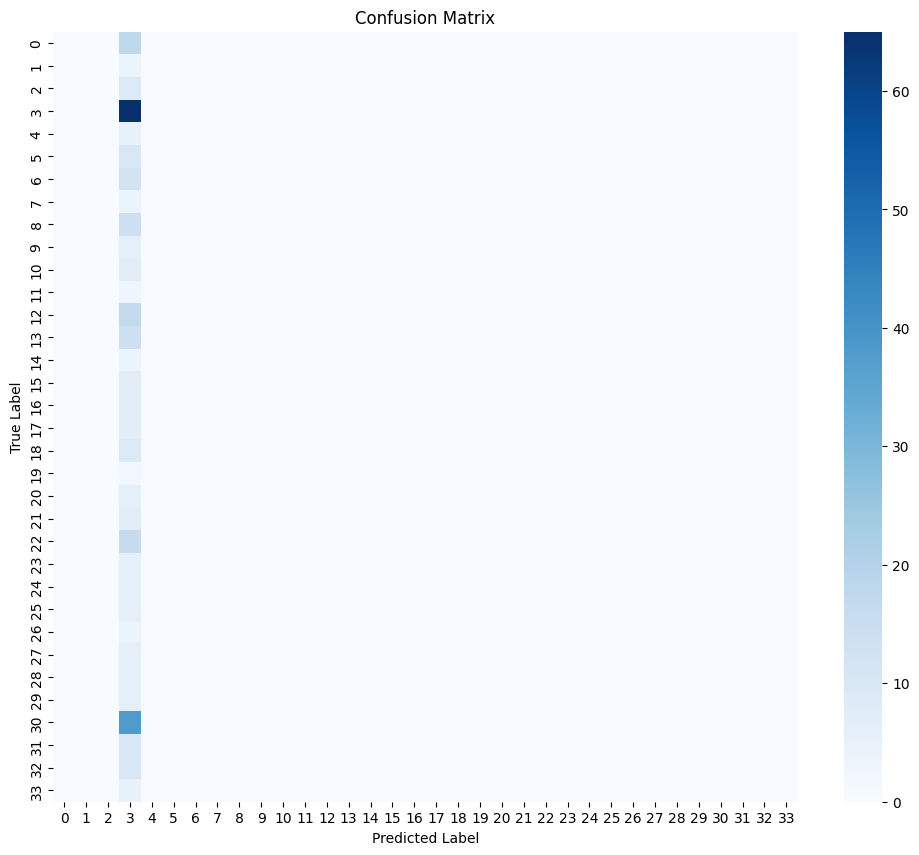

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**raining History (Accuracy & Loss)**

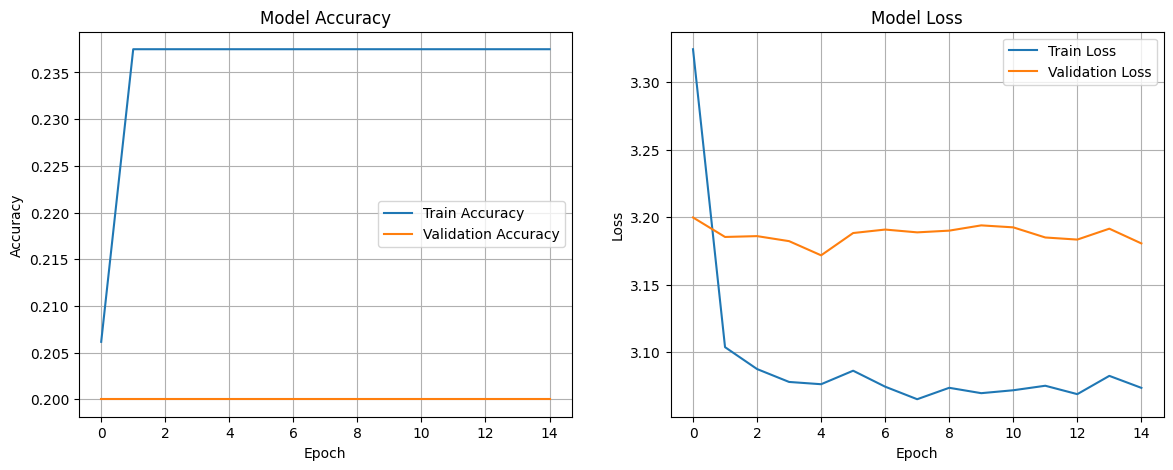

In [53]:
# 5. Training History Plots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

 Model saved to Google Drive!
✅ Confusion Matrix saved!
✅ ROC Curve saved!


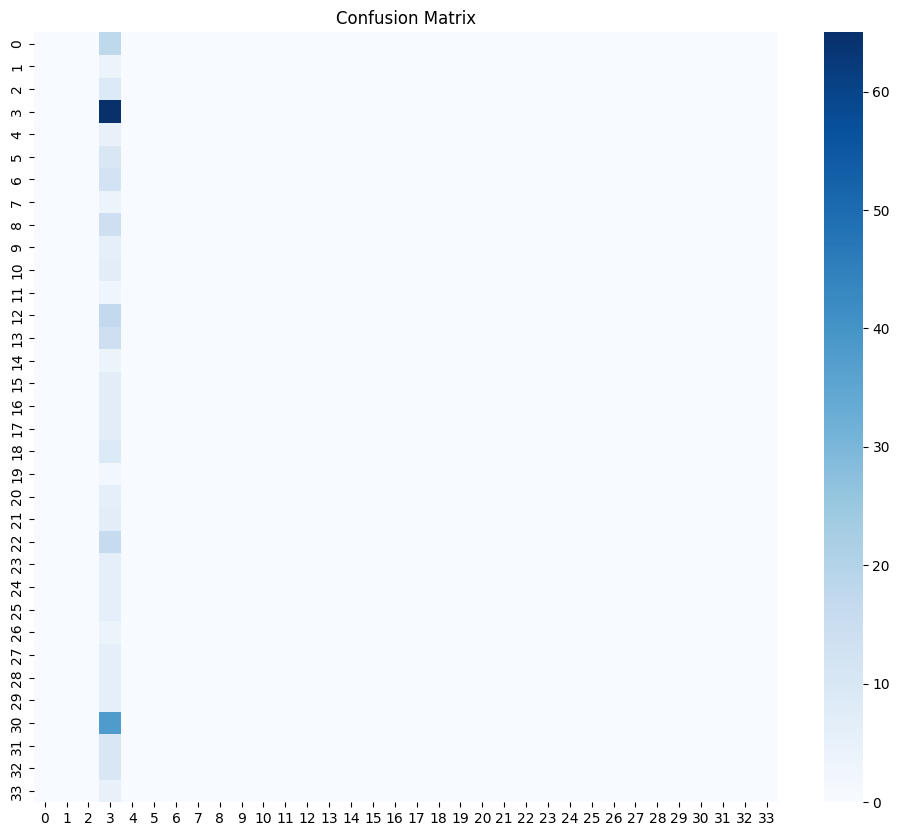

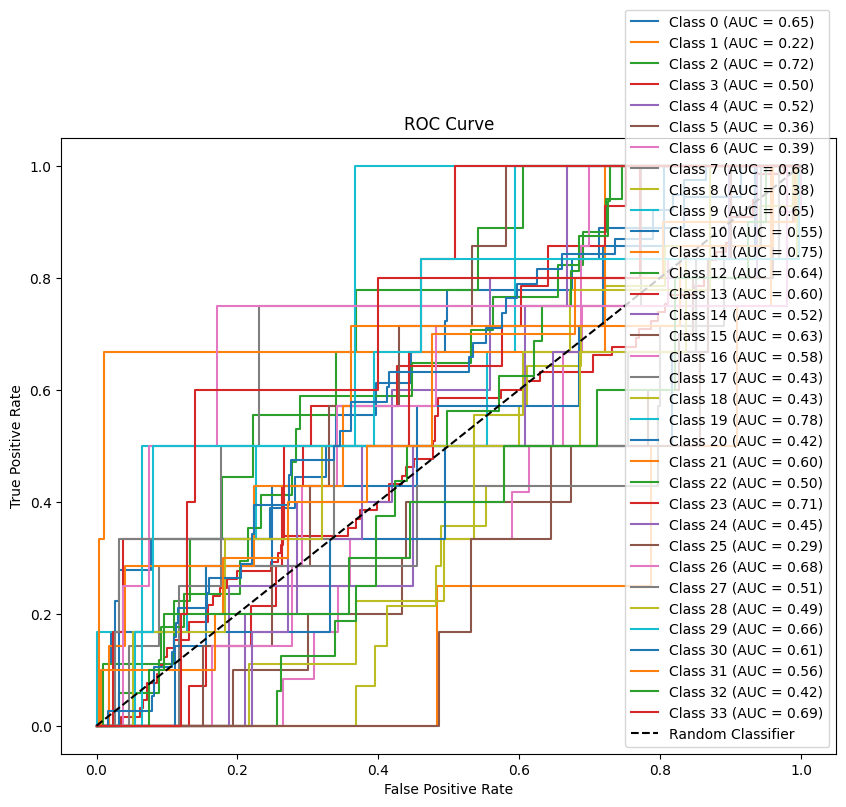

In [55]:
import shutil
import os

# 1. Create a folder in your Drive to store results
drive_save_path = "/content/drive/MyDrive/Colab Notebooks/VGG19_LFW_Results"
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)
    print(f"Created folder: {drive_save_path}")

# 2. Save your trained model
# (This copies the file we saved during training to your Drive)
try:
    shutil.copy("vgg19_best_model.keras", f"{drive_save_path}/vgg19_best_model.keras")
    print(" Model saved to Google Drive!")
except FileNotFoundError:
    print(" Could not find 'vgg19_best_model.keras'. Did the training finish?")

# 3. Save your Evaluation Charts
# If you ran the evaluation cell, save the plot figures
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(f"{drive_save_path}/confusion_matrix.png")
print("✅ Confusion Matrix saved!")

# Prepare data for ROC curve
y_test_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr = dict()
tpr = dict()

plt.figure(figsize=(10, 8))
# (Re-plotting ROC to save it)
for i in range(NUM_CLASSES):
    # Ensure there are positive samples for the class in the test set
    # and that the class is among the top 5 to plot (optional, can plot all)
    if np.sum(y_test_bin[:, i]) > 0:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc(fpr[i], tpr[i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(f"{drive_save_path}/roc_curve.png")
print("✅ ROC Curve saved!")